In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

In [2]:
import sys
import os

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path+"\\tools")
import hsi_io as io
import hsi_decompositions as dc
print(module_path)
sys.path


D:\elena\onedrive\OneDrive - 東工大未来研情報イノベーションコア\titech\research\experiments\medHSI\src\python


['D:\\elena\\onedrive\\OneDrive - 東工大未来研情報イノベーションコア\\titech\\research\\experiments\\medHSI\\src\\python\\tests',
 'D:\\elena\\Google Drive\\titech\\research\\experiments\\macroHSI\\src\\python\\MacroHSI\\macrohsi\\tests',
 'D:\\elena\\Google Drive\\titech\\research\\experiments\\macroHSI\\src\\python\\MacroHSI\\macrohsi\\tools',
 'C:\\Users\\foxel\\anaconda3\\envs\\hsi-dev\\python38.zip',
 'C:\\Users\\foxel\\anaconda3\\envs\\hsi-dev\\DLLs',
 'C:\\Users\\foxel\\anaconda3\\envs\\hsi-dev\\lib',
 'C:\\Users\\foxel\\anaconda3\\envs\\hsi-dev',
 '',
 'C:\\Users\\foxel\\anaconda3\\envs\\hsi-dev\\lib\\site-packages',
 'C:\\Users\\foxel\\anaconda3\\envs\\hsi-dev\\lib\\site-packages\\win32',
 'C:\\Users\\foxel\\anaconda3\\envs\\hsi-dev\\lib\\site-packages\\win32\\lib',
 'C:\\Users\\foxel\\anaconda3\\envs\\hsi-dev\\lib\\site-packages\\Pythonwin',
 'C:\\Users\\foxel\\anaconda3\\envs\\hsi-dev\\lib\\site-packages\\IPython\\extensions',
 'C:\\Users\\foxel\\.ipython',
 'D:\\elena\\onedrive\\OneDrive - 

In [3]:
import configparser

settings_file = os.path.dirname(os.path.dirname(module_path)) + "\\conf" + "\\config.ini"
settings_file

config = configparser.ConfigParser()
config.read(settings_file, encoding = 'utf-8')
config.sections()

['Data Settings',
 'Directories',
 'Folder Names',
 'File Names',
 'Run Settings',
 'Save Settings']

In [4]:
fpath = config['Directories']['outputDir'] + "000-Datasets" + "\\hsi_normalized_full.h5"  
fpath


'D:\\elena\\mspi\\output\\000-Datasets\\hsi_normalized_full.h5'

In [5]:
f = io.load_from_h5(fpath)
list(f.keys())


['sample150',
 'sample153',
 'sample157',
 'sample160',
 'sample163',
 'sample166',
 'sample169',
 'sample172',
 'sample175',
 'sample178',
 'sample181',
 'sample184',
 'sample187',
 'sample190',
 'sample193',
 'sample196',
 'sample199',
 'sample205',
 'sample209',
 'sample212']

In [6]:
for keyz in list(f.keys()):
    print(f[keyz].shape)

(311, 158, 180)
(311, 198, 324)
(311, 132, 108)
(311, 120, 164)
(311, 72, 80)
(311, 244, 308)
(311, 208, 224)
(311, 244, 212)
(311, 234, 212)
(311, 258, 424)
(311, 342, 332)
(311, 282, 436)
(311, 376, 236)
(311, 232, 428)
(311, 392, 236)
(311, 126, 128)
(311, 222, 232)
(311, 392, 696)
(311, 974, 1356)
(311, 280, 196)


In [8]:
#dataz =  io.load_from_h5(fpath)
dataList = io.load_dataset(fpath, 'image')
print("images in dataset", len(dataList))
print("datatype ", (dataList[0]).dtype, "1st image size", dataList[0].shape)

TypeError: 'tuple' object is not callable

In [11]:
croppedData = io.center_crop_list(dataList, 70, 70, True)

ValueError: Input array has to be 3-dimensional for grayscale images, or 4-dimensional with `multichannel=True` for color images.

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(croppedData, test_size=0.2, random_state=42)
print("xtrain: ", len(X_train),", xtest: ", len(X_test))

xtrain:  16 , xtest:  4


In [78]:
from keras.layers import Dense, Flatten, Reshape, Input, InputLayer
from keras.models import Sequential, Model

def build_autoencoder(img_shape, code_size):
    # The encoder
    encoder = Sequential()
    encoder.add(InputLayer(img_shape))
    encoder.add(Flatten())
    encoder.add(Dense(code_size, activation='relu'))

    # The decoder
    decoder = Sequential()
    decoder.add(InputLayer((code_size,)))
    decoder.add(Dense(np.prod(img_shape), activation='sigmoid')) # np.prod(img_shape) is the same as 32*32*3, it's more generic than saying 3072
    decoder.add(Reshape(img_shape))

    return encoder, decoder

In [79]:
img_shape = X_train[0].shape

encoder, decoder = build_autoencoder(img_shape, 1024)

inp = Input(img_shape)
code = encoder(inp)
reconstruction = decoder(code)

autoencoder = Model(inp,reconstruction)
#autoencoder.compile(optimizer='adamax', loss='mse')
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

print(autoencoder.summary())

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_18 (InputLayer)       [(None, 311, 70, 70)]     0         
                                                                 
 sequential_10 (Sequential)  (None, 1024)              1560474624
                                                                 
 sequential_11 (Sequential)  (None, 311, 70, 70)       1561997500
                                                                 
Total params: -1,172,495,172
Trainable params: -1,172,495,172
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
print(len(X_train))
print(np.array(X_train).shape)
X_train2 = np.array(X_train)
X_test2 = np.array(X_test)
history = autoencoder.fit(x=X_train2, y=X_train2, epochs=80,
                validation_data=(X_test2, X_test2))

16
(16, 311, 70, 70)
Epoch 1/80
1/1 [==============================] - 24s 24s/step - loss: 0.2498 - val_loss: 0.2499
Epoch 2/80
1/1 [==============================] - 7s 7s/step - loss: 0.2498 - val_loss: 0.2498
Epoch 3/80
1/1 [==============================] - 7s 7s/step - loss: 0.2498 - val_loss: 0.2498
Epoch 4/80
1/1 [==============================] - 7s 7s/step - loss: 0.2498 - val_loss: 0.2498
Epoch 5/80
1/1 [==============================] - 7s 7s/step - loss: 0.2497 - val_loss: 0.2498
Epoch 6/80
1/1 [==============================] - 7s 7s/step - loss: 0.2497 - val_loss: 0.2497
Epoch 7/80
1/1 [==============================] - 7s 7s/step - loss: 0.2497 - val_loss: 0.2497
Epoch 8/80
1/1 [==============================] - 7s 7s/step - loss: 0.2497 - val_loss: 0.2497
Epoch 9/80
1/1 [==============================] - 7s 7s/step - loss: 0.2496 - val_loss: 0.2496
Epoch 10/80
1/1 [==============================] - 7s 7s/step - loss: 0.2496 - val_loss: 0.2496
Epoch 11/80
1/1 [=========

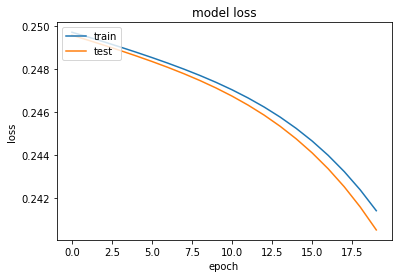

In [71]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()